<a href="https://colab.research.google.com/github/jfforero/Prosodic_Irony/blob/main/3BERT_2DYNA_ROUNDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# 3BERT_2DYNA_ROUNDS

In [ ]:
# Step 1: Unzip the dataset (assuming it’s uploaded to Colab)
!unzip dynasent-v1.1.zip -d dynasent-v1.1

Archive:  dynasent-v1.1.zip
   creating: dynasent-v1.1/dynasent-v1.1/
  inflating: dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-train.jsonl  
   creating: dynasent-v1.1/__MACOSX/
   creating: dynasent-v1.1/__MACOSX/dynasent-v1.1/
  inflating: dynasent-v1.1/__MACOSX/dynasent-v1.1/._dynasent-v1.1-round01-yelp-train.jsonl  
  inflating: dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-dev.jsonl  
  inflating: dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-test.jsonl  
  inflating: dynasent-v1.1/__MACOSX/dynasent-v1.1/._dynasent-v1.1-round02-dynabench-test.jsonl  
  inflating: dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-dev.jsonl  
  inflating: dynasent-v1.1/__MACOSX/dynasent-v1.1/._dynasent-v1.1-round02-dynabench-dev.jsonl  
  inflating: dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-train.jsonl  
  inflating: dynasent-v1.1/__MACOSX/dynasent-v1.1/._dynasent-v1.1-round02-dynabench-train.jsonl  
  inflating: dynasent-v1.1/dynasent-v1

In [ ]:
# Import necessary libraries
import zipfile
import os
import json
import random
from collections import Counter
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

# Round 1 file paths
train_filename_r1 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-train.jsonl'
val_filename_r1 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-dev.jsonl'
test_filename_r1 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-test.jsonl'

# Round 2 file paths
train_filename_r2 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-train.jsonl'
val_filename_r2 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-dev.jsonl'
test_filename_r2 = '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-test.jsonl'

# Hyperparameters
BATCH_SIZE = 16
EPOCHS_R1 = 5
EPOCHS_R2 = 3
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-6

# Function to load and filter datasets based on specific labels
def load_dataset(filename, labels=None):
    data = []
    with open(filename) as f:
        for line in f:
            d = json.loads(line)
            if labels is None or d['gold_label'] in labels:
                data.append(d)
    return data

# Define ternary labels
ternary_labels = ('positive', 'negative', 'neutral')

# Load Round 1 and Round 2 data
train_data_r1 = load_dataset(train_filename_r1, labels=ternary_labels)
val_data_r1 = load_dataset(val_filename_r1, labels=ternary_labels)
test_data_r1 = load_dataset(test_filename_r1, labels=ternary_labels)

train_data_r2 = load_dataset(train_filename_r2, labels=ternary_labels)
val_data_r2 = load_dataset(val_filename_r2, labels=ternary_labels)
test_data_r2 = load_dataset(test_filename_r2, labels=ternary_labels)

# Balance Round 1 by undersampling
data_by_label_r1 = {'positive': [], 'negative': [], 'neutral': []}
for d in train_data_r1:
    data_by_label_r1[d['gold_label']].append(d)

min_size_r1 = min(len(data_by_label_r1['positive']), len(data_by_label_r1['negative']), len(data_by_label_r1['neutral']))
balanced_train_data_r1 = []
for label in data_by_label_r1:
    balanced_train_data_r1.extend(random.sample(data_by_label_r1[label], min_size_r1))
random.shuffle(balanced_train_data_r1)

# Balance Round 2 by undersampling
data_by_label_r2 = {'positive': [], 'negative': [], 'neutral': []}
for d in train_data_r2:
    data_by_label_r2[d['gold_label']].append(d)

min_size_r2 = min(len(data_by_label_r2['positive']), len(data_by_label_r2['negative']), len(data_by_label_r2['neutral']))
balanced_train_data_r2 = []
for label in data_by_label_r2:
    balanced_train_data_r2.extend(random.sample(data_by_label_r2[label], min_size_r2))
random.shuffle(balanced_train_data_r2)


In [ ]:
# Import Counter to summarize class distribution in each dataset
from collections import Counter

# Print class distribution for Round 1 after balancing
print("Round 1 (Balanced):")
train_labels_counter_r1 = Counter([d['gold_label'] for d in balanced_train_data_r1])
print(f"Training set: {train_labels_counter_r1}")
val_labels_counter_r1 = Counter([d['gold_label'] for d in val_data_r1])
print(f"Validation set: {val_labels_counter_r1}")
test_labels_counter_r1 = Counter([d['gold_label'] for d in test_data_r1])
print(f"Test set: {test_labels_counter_r1}")

# Print class distribution for Round 2 (unbalanced, original)
print("\nRound 2 (Original, Unbalanced):")
train_labels_counter_r2 = Counter([d['gold_label'] for d in balanced_train_data_r2])
print(f"Training set: {train_labels_counter_r2}")
val_labels_counter_r2 = Counter([d['gold_label'] for d in val_data_r2])
print(f"Validation set: {val_labels_counter_r2}")
test_labels_counter_r2 = Counter([d['gold_label'] for d in test_data_r2])
print(f"Test set: {test_labels_counter_r2}")


Round 1 (Balanced):
Training set: Counter({'positive': 14021, 'neutral': 14021, 'negative': 14021})
Validation set: Counter({'positive': 1200, 'neutral': 1200, 'negative': 1200})
Test set: Counter({'negative': 1200, 'positive': 1200, 'neutral': 1200})

Round 2 (Original, Unbalanced):
Training set: Counter({'neutral': 2448, 'positive': 2448, 'negative': 2448})
Validation set: Counter({'neutral': 240, 'negative': 240, 'positive': 240})
Test set: Counter({'positive': 240, 'neutral': 240, 'negative': 240})


In [ ]:
# Prepare data for training
def prepare_data(data):
    sentences = [d['sentence'] for d in data]
    labels = [0 if d['gold_label'] == 'negative' else 1 if d['gold_label'] == 'neutral' else 2 for d in data]
    return sentences, labels

# Prepare balanced Round 1 and Round 2 data
train_sentences_r1, train_labels_r1 = prepare_data(balanced_train_data_r1)
val_sentences_r1, val_labels_r1 = prepare_data(val_data_r1)
test_sentences_r1, test_labels_r1 = prepare_data(test_data_r1)

train_sentences_r2, train_labels_r2 = prepare_data(balanced_train_data_r2)
val_sentences_r2, val_labels_r2 = prepare_data(val_data_r2)
test_sentences_r2, test_labels_r2 = prepare_data(test_data_r2)

# Load BERT model and tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to encode data for BERT input
def encode_data(sentences, labels):
    input_ids, attention_masks = [], []
    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=MAX_SEQ_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return (
        tf.convert_to_tensor(input_ids),
        tf.convert_to_tensor(attention_masks),
        tf.convert_to_tensor(labels)
    )

# Encode Round 1 and Round 2 data
train_input_ids_r1, train_attention_masks_r1, train_labels_r1 = encode_data(train_sentences_r1, train_labels_r1)
val_input_ids_r1, val_attention_masks_r1, val_labels_r1 = encode_data(val_sentences_r1, val_labels_r1)
test_input_ids_r1, test_attention_masks_r1, test_labels_r1 = encode_data(test_sentences_r1, test_labels_r1)

train_input_ids_r2, train_attention_masks_r2, train_labels_r2 = encode_data(train_sentences_r2, train_labels_r2)
val_input_ids_r2, val_attention_masks_r2, val_labels_r2 = encode_data(val_sentences_r2, val_labels_r2)
test_input_ids_r2, test_attention_masks_r2, test_labels_r2 = encode_data(test_sentences_r2, test_labels_r2)

# Create TensorFlow datasets
def create_tf_dataset(input_ids, attention_masks, labels):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids, 'attention_mask': attention_masks}, labels))
    return dataset.shuffle(len(labels)).batch(BATCH_SIZE)

# Create datasets for Round 1
train_dataset_r1 = create_tf_dataset(train_input_ids_r1, train_attention_masks_r1, train_labels_r1)
val_dataset_r1 = create_tf_dataset(val_input_ids_r1, val_attention_masks_r1, val_labels_r1)
test_dataset_r1 = create_tf_dataset(test_input_ids_r1, test_attention_masks_r1, test_labels_r1)

# Create datasets for balanced Round 2
train_dataset_r2 = create_tf_dataset(train_input_ids_r2, train_attention_masks_r2, train_labels_r2)
val_dataset_r2 = create_tf_dataset(val_input_ids_r2, val_attention_masks_r2, val_labels_r2)
test_dataset_r2 = create_tf_dataset(test_input_ids_r2, test_attention_masks_r2, test_labels_r2)

# Calculate class weights for Round 2
label_counts_r2 = Counter([d['gold_label'] for d in train_data_r2])
total_r2 = sum(label_counts_r2.values())
class_weights_r2 = {
    0: total_r2 / label_counts_r2['negative'],  # 'negative' mapped to 0
    1: total_r2 / label_counts_r2['neutral'],   # 'neutral' mapped to 1
    2: total_r2 / label_counts_r2['positive']   # 'positive' mapped to 2
}

# Compile and train the model on balanced Round 1 data
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=1e-8)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

print("Training on balanced Round 1 data...")
history_r1 = model.fit(
    train_dataset_r1,
    epochs=EPOCHS_R1,
    validation_data=val_dataset_r1
)

# Fine-tune the model on balanced Round 2 data with weighted loss
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

print("Fine-tuning on balanced Round 2 data with weighted loss...")
history_r2 = model.fit(
    train_dataset_r2,
    epochs=EPOCHS_R2,
    validation_data=val_dataset_r2,
    class_weight=class_weights_r2
)

# Evaluate on both test sets
print("Evaluating on Round 1 test set...")
test_loss_r1, test_accuracy_r1 = model.evaluate(test_dataset_r1)
print(f"Round 1 Test Accuracy: {test_accuracy_r1}")

print("Evaluating on Round 2 test set...")
test_loss_r2, test_accuracy_r2 = model.evaluate(test_dataset_r2)
print(f"Round 2 Test Accuracy: {test_accuracy_r2}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training on balanced Round 1 data...
Epoch 1/5
2629/2629 [==============================] - 665s 235ms/step - loss: 0.8562 - accuracy: 0.6132 - val_loss: 0.7044 - val_accuracy: 0.7031
Epoch 2/5
2629/2629 [==============================] - 611s 232ms/step - loss: 0.6850 - accuracy: 0.7128 - val_loss: 0.6302 - val_accuracy: 0.7353
Epoch 3/5
2629/2629 [==============================] - 611s 232ms/step - loss: 0.6212 - accuracy: 0.7459 - val_loss: 0.6075 - val_accuracy: 0.7481
Epoch 4/5
2629/2629 [==============================] - 611s 232ms/step - loss: 0.5669 - accuracy: 0.7720 - val_loss: 0.5986 - val_accuracy: 0.7586
Epoch 5/5
2629/2629 [==============================] - 611s 232ms/step - loss: 0.5208 - accuracy: 0.7940 - val_loss: 0.6083 - val_accuracy: 0.7550
Fine-tuning on balanced Round 2 data with weighted loss...
Epoch 1/3
459/459 [==============================] - 122s 241ms/step - loss: 1.8286 - accuracy: 0.7599 - val_loss: 0.9281 - val_accuracy: 0.6250
Epoch 2/3
459/459 [=====

In [ ]:
# Save the trained model
model_save_path = '3BERT_2DYNAROUND_MODEL'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)



('3BERT_2DYNAROUND_MODEL/tokenizer_config.json',
 '3BERT_2DYNAROUND_MODEL/special_tokens_map.json',
 '3BERT_2DYNAROUND_MODEL/vocab.txt',
 '3BERT_2DYNAROUND_MODEL/added_tokens.json')

In [ ]:
import shutil
# Zip the saved model directory
shutil.make_archive(model_save_path, 'zip', model_save_path)

'/content/3BERT_2DYNAROUND_MODEL.zip'

113/113 [==============================] - 21s 152ms/step


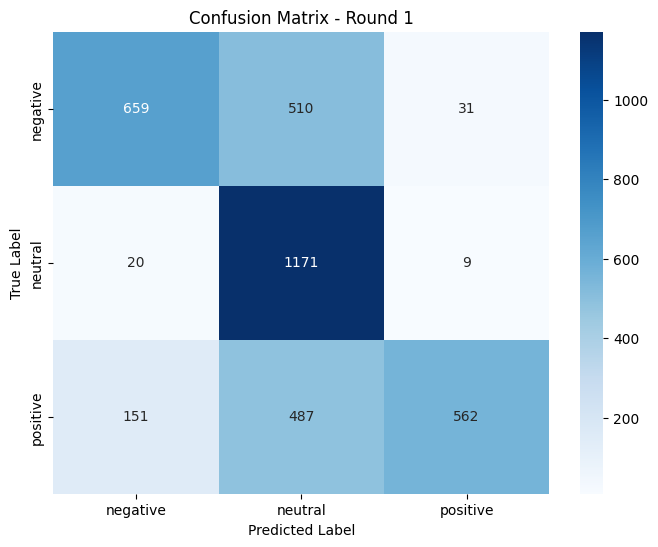


Classification Report for Round 1:
               precision    recall  f1-score   support

    negative       0.79      0.55      0.65      1200
     neutral       0.54      0.98      0.70      1200
    positive       0.93      0.47      0.62      1200

    accuracy                           0.66      3600
   macro avg       0.76      0.66      0.66      3600
weighted avg       0.76      0.66      0.66      3600

23/23 [==============================] - 3s 150ms/step


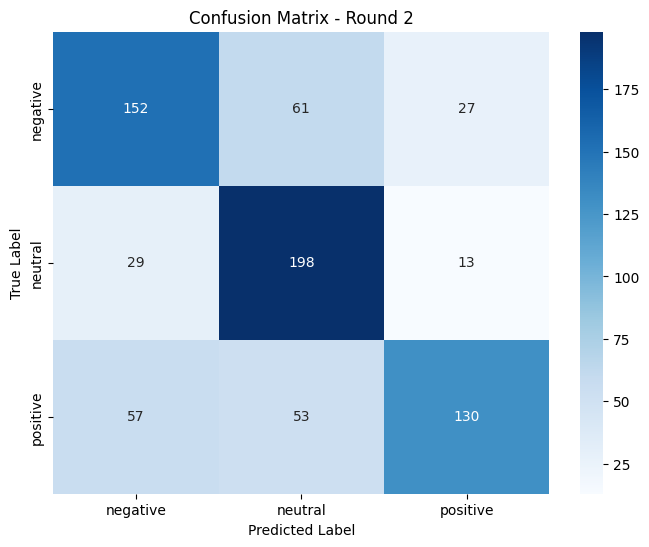


Classification Report for Round 2:
               precision    recall  f1-score   support

    negative       0.64      0.63      0.64       240
     neutral       0.63      0.82      0.72       240
    positive       0.76      0.54      0.63       240

    accuracy                           0.67       720
   macro avg       0.68      0.67      0.66       720
weighted avg       0.68      0.67      0.66       720



In [ ]:
import json
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define paths for both test datasets
test_filenames = {
    "Round 1": '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round01-yelp-test.jsonl',
    "Round 2": '/content/dynasent-v1.1/dynasent-v1.1/dynasent-v1.1-round02-dynabench-test.jsonl'
}

# Define ternary labels
ternary_labels = ('positive', 'negative', 'neutral')

# Load the test dataset
def load_test_dataset(filename, labels=None):
    data = []
    with open(filename) as f:
        for line in f:
            d = json.loads(line)
            if labels is None or d['gold_label'] in labels:
                data.append(d)
    return data

# Prepare test sentences and labels
def prepare_data(test_dataset):
    test_sentences = [d['sentence'] for d in test_dataset]
    true_labels = [0 if d['gold_label'] == 'negative' else 1 if d['gold_label'] == 'neutral' else 2 for d in test_dataset]
    return test_sentences, true_labels

# Tokenize the test data
def encode_data(sentences):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=MAX_SEQ_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Function to evaluate the model and plot confusion matrix
def evaluate_model(test_filename, round_name):
    # Load test dataset
    test_dataset = load_test_dataset(test_filename, labels=ternary_labels)

    # Prepare test sentences and labels
    test_sentences, true_labels = prepare_data(test_dataset)

    # Encode the test sentences
    test_input_ids, test_attention_masks = encode_data(test_sentences)

    # Generate predictions
    outputs = model.predict({'input_ids': test_input_ids, 'attention_mask': test_attention_masks})
    predicted_labels = tf.argmax(outputs.logits, axis=1).numpy()

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    class_names = ['negative', 'neutral', 'positive']

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {round_name}')
    plt.show()

    # Classification report
    print(f"\nClassification Report for {round_name}:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

# Evaluate for both rounds
for round_name, filename in test_filenames.items():
    evaluate_model(filename, round_name)


In [ ]:
!unzip  /content/drive/MyDrive/3BERT_2DYNAROUND_MODEL.zip -d /content/3BERT_2DYNAROUND_MODEL

Archive:  /content/drive/MyDrive/3BERT_2DYNAROUND_MODEL.zip
replace /content/3BERT_2DYNAROUND_MODEL/tf_model.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf


MAX_SEQ_LEN = 512  # Increased sequence length

# Load the saved model and tokenizer
model_save_path = '/content/3BERT_2DYNAROUND_MODEL'
model = TFBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# The sentence to predict
sentence = "mm what"

# Tokenize and prepare the input
inputs = tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
    max_length=MAX_SEQ_LEN,
    padding='max_length',
    truncation=True,
    return_tensors="tf"
)

# Make prediction
outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
logits = outputs.logits
predicted_class = tf.argmax(logits, axis=1).numpy()[0]

# Map predicted class to sentiment
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_sentiment = sentiment_map[predicted_class]

print(f"Predicted sentiment for '{sentence}': {predicted_sentiment}")


Some layers from the model checkpoint at /content/3BERT_2DYNAROUND_MODEL were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/3BERT_2DYNAROUND_MODEL.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predicted sentiment for 'mm what': neutral


# IEMOCAP PREDICTION

In [ ]:
# Download IEMOCAP
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download mouadriali/iemocap-transcriptions-english-french

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mouadriali/iemocap-transcriptions-english-french
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.77G/5.78G [00:35<00:00, 180MB/s]
100% 5.78G/5.78G [00:35<00:00, 176MB/s]


In [ ]:
!unzip '/content/iemocap-transcriptions-english-french.zip'

Streaming output truncated to the last 5000 lines.
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M016_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M017_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M018_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M019_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M020_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M021_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M022_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M023_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M024_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M025_mfcc.png  
  inflati

In [ ]:
import pandas as pd

df = pd.read_csv("/content/iemocapTrans.csv")
df = df.replace(regex=['<br/>'],value=' ')
df = df.replace(regex=['\n'],value=' ')
df = df.loc[:,["titre", "to_translate","emotion"]]

df

,titre,to_translate,emotion
0,Ses02M_impro02_F000,I don't want you to go.,sad
1,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",sad
2,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,sad
3,Ses02M_impro02_F002,I don't want to be a single mom.,sad
4,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,sad
...,...,...,...
10034,Ses01M_script01_3_F028,Everything Chris do you understand that? To ...,ang
10035,Ses01M_script01_3_F029,And your money there's nothing wrong in your ...,fru
10036,Ses01M_script01_3_M042,Annie...,hap
10037,Ses01M_script01_3_M043,I'm going to make a fortune for you.,hap


In [ ]:
my_table1 = df.loc[:,["titre", "to_translate","emotion"]]
my_table1

,titre,to_translate,emotion
0,Ses02M_impro02_F000,I don't want you to go.,sad
1,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",sad
2,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,sad
3,Ses02M_impro02_F002,I don't want to be a single mom.,sad
4,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,sad
...,...,...,...
10034,Ses01M_script01_3_F028,Everything Chris do you understand that? To ...,ang
10035,Ses01M_script01_3_F029,And your money there's nothing wrong in your ...,fru
10036,Ses01M_script01_3_M042,Annie...,hap
10037,Ses01M_script01_3_M043,I'm going to make a fortune for you.,hap


In [ ]:
!unzip  /content/drive/MyDrive/3BERT_2DYNAROUND_MODEL.zip -d /content/3BERT_2DYNAROUND_MODEL

Archive:  /content/drive/MyDrive/3BERT_2DYNAROUND_MODEL.zip
  inflating: /content/3BERT_2DYNAROUND_MODEL/tf_model.h5  
  inflating: /content/3BERT_2DYNAROUND_MODEL/tokenizer_config.json  
  inflating: /content/3BERT_2DYNAROUND_MODEL/vocab.txt  
  inflating: /content/3BERT_2DYNAROUND_MODEL/special_tokens_map.json  
  inflating: /content/3BERT_2DYNAROUND_MODEL/config.json  


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf


MAX_SEQ_LEN = 512  # Increased sequence length

# Load the saved model and tokenizer
model_save_path = '/content/3BERT_2DYNAROUND_MODEL'
model = TFBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# The sentence to predict
sentence = "mm what"

# Tokenize and prepare the input
inputs = tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
    max_length=MAX_SEQ_LEN,
    padding='max_length',
    truncation=True,
    return_tensors="tf"
)

# Make prediction
outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
logits = outputs.logits
predicted_class = tf.argmax(logits, axis=1).numpy()[0]

# Map predicted class to sentiment
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_sentiment = sentiment_map[predicted_class]

print(f"Predicted sentiment for '{sentence}': {predicted_sentiment}")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/3BERT_2DYNAROUND_MODEL.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predicted sentiment for 'mm what': neutral


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

# Load the dataset
df = pd.read_csv("/content/iemocapTrans.csv")
df = df.replace(regex=['<br/>'], value=' ')
df = df.replace(regex=['\n'], value=' ')
df = df.loc[:, ["titre", "to_translate", "emotion"]]

# Load the model and tokenizer
MAX_SEQ_LEN = 512
model_save_path = '/content/3BERT_2DYNAROUND_MODEL'
model = TFBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Sentiment map
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}

# Predict sentiment for each row
semantic_analysis = []
for sentence in df['to_translate']:
    # Tokenize and prepare the input
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_SEQ_LEN,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

    # Make prediction
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    predicted_sentiment = sentiment_map[predicted_class]

    # Append the result
    semantic_analysis.append(predicted_sentiment)

# Add the predictions to the DataFrame
df['Semantic Analysis'] = semantic_analysis

# Save the new DataFrame
df.to_csv('/content/iemocapTrans_with_semantic_analysis.csv', index=False)

print("New table with Semantic Analysis saved as 'iemocapTrans_with_semantic_analysis.csv'")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/3BERT_2DYNAROUND_MODEL.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


New table with Semantic Analysis saved as 'iemocapTrans_with_semantic_analysis.csv'


In [ ]:
df


,titre,to_translate,emotion,Semantic Analysis
0,Ses02M_impro02_F000,I don't want you to go.,sad,negative
1,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",sad,neutral
2,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,sad,negative
3,Ses02M_impro02_F002,I don't want to be a single mom.,sad,neutral
4,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,sad,neutral
...,...,...,...,...
10034,Ses01M_script01_3_F028,Everything Chris do you understand that? To ...,ang,neutral
10035,Ses01M_script01_3_F029,And your money there's nothing wrong in your ...,fru,negative
10036,Ses01M_script01_3_M042,Annie...,hap,neutral
10037,Ses01M_script01_3_M043,I'm going to make a fortune for you.,hap,neutral


In [ ]:
# create a copy of my_table1
my_table = df.copy()


my_table = my_table.rename(columns={"titre": "File", "to_translate": "Text", "emotion": "Acoustic Annotation"})
my_table = my_table.loc[:, ["File", "Text", "Acoustic Annotation", "Semantic Analysis"]]

my_table

,File,Text,Acoustic Annotation,Semantic Analysis
0,Ses02M_impro02_F000,I don't want you to go.,sad,negative
1,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",sad,neutral
2,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,sad,negative
3,Ses02M_impro02_F002,I don't want to be a single mom.,sad,neutral
4,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,sad,neutral
...,...,...,...,...
10034,Ses01M_script01_3_F028,Everything Chris do you understand that? To ...,ang,neutral
10035,Ses01M_script01_3_F029,And your money there's nothing wrong in your ...,fru,negative
10036,Ses01M_script01_3_M042,Annie...,hap,neutral
10037,Ses01M_script01_3_M043,I'm going to make a fortune for you.,hap,neutral
